<a href="https://colab.research.google.com/github/dibadabir/ML---Assignment/blob/main/Unsupervised_Face_Recognition_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install face-recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=420e2db3b465e6a61e3ab4fae39ade7a46f856217a7984168564f5192c5e64eb
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
# import neccassary libraries

import os
import pickle
import numpy as np
import cv2
import face_recognition
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
from imutils import paths, build_montages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def extract_frames(video_path):
    # Create folder to save frames
    video_name = video_path.split("/")[-1].split(".")[0]
    folder_frames = f'/content/drive/MyDrive/Data'
    os.makedirs(folder_frames, exist_ok=True)

    # Load the cascade face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Read the video file
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    save_count = 0

    while (cap.isOpened()):
        ret, frame = cap.read()

        # Break loop if video ends
        if ret == False:
            break

        # Convert frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

        if(len(faces) > 0):
            # Save frame as an image file every tenth frame
            if save_count % 3 == 0:
                frame_filename = f"{video_name}.{frame_count}.jpg"
                frame_path = os.path.join(folder_frames, frame_filename)
                cv2.imwrite(frame_path, frame)
                print(frame_count)
                frame_count += 1

            save_count += 1

    # Release video capture object
    cap.release()
    cv2.destroyAllWindows()

    print(f"Total frames saved: {frame_count}")

In [ ]:
extract_frames('/content/drive/MyDrive/Diba.MOV')

In [ ]:
extract_frames('/content/drive/MyDrive/Jen.MOV')

In [ ]:
extract_frames('/content/drive/MyDrive/Saleh.MOV')

In [ ]:
extract_frames('/content/drive/MyDrive/Maciej.MOV')

In [28]:
# Specify paths

dataset_path = '/content/drive/MyDrive/Data'
encodings_path = '/content/drive/MyDrive/New Folder/encodings.pickle'

# Initialize variables
data = []

# Get image paths from dataset directory
imagePaths = list(paths.list_images(dataset_path))

# Loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
  print('[Info] processing images {}/{}'.format(i+1, len(imagePaths)))
  print(imagePaths)

  # Read the image
  image = cv2.imread(imagePath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Detect faces
  boxes = face_recognition.face_locations(image)

  # Extract facial encodings
  encodings = face_recognition.face_encodings(image, boxes)

  # Build dictionary
  d = [{'imagePath': imagePath, 'loc' : box, 'encoding' : enc}
       for (box,enc) in zip(boxes, encodings)]
  data.extend(d)

# Save encodings to file location
with open(encodings_path, 'wb') as f:
  pickle.dump(data, f)

print('Encoding of images saved in {}'.format(encodings_path))

[Info] processing images 1/145
['/content/drive/MyDrive/Data/Diba.0.jpg', '/content/drive/MyDrive/Data/Diba.2.jpg', '/content/drive/MyDrive/Data/Diba.4.jpg', '/content/drive/MyDrive/Data/Diba.6.jpg', '/content/drive/MyDrive/Data/Diba.8.jpg', '/content/drive/MyDrive/Data/Diba.10.jpg', '/content/drive/MyDrive/Data/Diba.11.jpg', '/content/drive/MyDrive/Data/Diba.13.jpg', '/content/drive/MyDrive/Data/Diba.15.jpg', '/content/drive/MyDrive/Data/Diba.19.jpg', '/content/drive/MyDrive/Data/Diba.21.jpg', '/content/drive/MyDrive/Data/Diba.23.jpg', '/content/drive/MyDrive/Data/Diba.24.jpg', '/content/drive/MyDrive/Data/Diba.26.jpg', '/content/drive/MyDrive/Data/Diba.28.jpg', '/content/drive/MyDrive/Data/Diba.30.jpg', '/content/drive/MyDrive/Data/Diba.31.jpg', '/content/drive/MyDrive/Data/Diba.35.jpg', '/content/drive/MyDrive/Data/Diba.38.jpg', '/content/drive/MyDrive/Data/Diba.40.jpg', '/content/drive/MyDrive/Data/Diba.42.jpg', '/content/drive/MyDrive/Data/Diba.44.jpg', '/content/drive/MyDrive/Dat

In [31]:
# Specify paths

H = '/content/drive/MyDrive/New Folder/encodings.pickle'
CLUSTERING_RESULT_PATH = '/content/drive/MyDrive/New Folder/KMeans Clustering Result'

# Create clustering results directory if it doesn't exist
if not os.path.exists(CLUSTERING_RESULT_PATH):
  os.mkdir(CLUSTERING_RESULT_PATH)

# Load encodings
print('[Info] loading encodings...')
data = pickle.load(open(encodings_path, 'rb'))
data = np.array(data)
encodings = [d['encoding'] for d in data]

# Convert encoding to numpy array
encodings = np.array(encodings)

# Perform KMeans clustering
print('[Info] Clustering...')
kmeans = KMeans(n_clusters=4)
labels = kmeans.fit_predict(encodings)

# Determine uniqe label IDs
labelIDs = np.unique(labels)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print('[Info] # unique face {}'.format(numUniqueFaces))

# Loop over unique label IDs
for labelID in labelIDs:
  print('[Info] faces for clustering: {}'.format(labelID))
  idxs = np.where(labels == labelID)[0]
  idxs = np.random.choice(idxs, size = min(25, len(idxs)), replace = False)#

  # Initialize list of faces
  faces = []

  # Loop over sampled indexes
  for i in idxs:
    image = cv2.imread(data[i]['imagePath'])
    (top, right, bottom, left) = data[i]['loc']
    face = image[top:bottom, left:right]

    # Resize face and add to faces list
    face = cv2.resize(face, (96,96), (5,5))
    faces.append(face)

  # Create montage
  montage = build_montages(faces, (96,96), (5,5))[0]

  # Save the output montage
  title = 'Cluster_{}'.format(labelID)
  cv2.imwrite(os.path.join(CLUSTERING_RESULT_PATH, title + '.jpg'), montage)

print('Clustering results saved in {}'.format(CLUSTERING_RESULT_PATH))

[Info] loading encodings...
[Info] Clustering...
[Info] # unique face 4
[Info] faces for clustering: 0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[Info] faces for clustering: 1
[Info] faces for clustering: 2
[Info] faces for clustering: 3
Clustering results saved in /content/drive/MyDrive/New Folder/KMeans Clustering Result


In [33]:
# Save model to a file
model_save_path = '/content/drive/MyDrive/New Folder/KMeans_model.pkl'
with open(model_save_path, 'wb') as f:
  pickle.dump(kmeans, f)

print(f'Kmeans model saved to {model_save_path}')


Kmeans model saved to /content/drive/MyDrive/New Folder/KMeans_model.pkl


Making predictions with the model

In [46]:
# Load the model
model_load_path = '/content/drive/MyDrive/KMeans_model.pkl'
with open(model_save_path, 'rb') as f:
  kmeans = pickle.load(f)

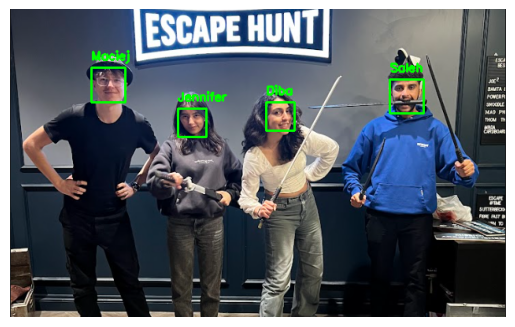

In [115]:
import cv2
import matplotlib.pyplot as plt

# Function to predict cluster name for a face encoding
def predict_cluster(encoding, kmeans_model, cluster_names):
    if encoding is not None:
        cluster_label = kmeans_model.predict([encoding])[0]
        cluster_name = cluster_names.get(cluster_label, f'Cluster {cluster_label}')
        return cluster_name
    else:
        return None

# Function to get face encodings and locations from an image
def get_face_encodings_and_locations(image_path):
    image = face_recognition.load_image_file(image_path)
    face_locations = face_recognition.face_locations(image)
    face_encodings = face_recognition.face_encodings(image, face_locations)
    return face_encodings, face_locations

# Manual cluster names
cluster_names = {
    0: "Saleh",
    1: "Jennifer",
    2: "Maciej",
    3: "Diba"
}

# Path to new image
new_image_path = '/content/drive/MyDrive/pred-2.PNG'

# Load the image
image = cv2.imread(new_image_path)

# Get face encodings and locations from the new image
face_encodings, face_locations = get_face_encodings_and_locations(new_image_path)

# Predict and display cluster labels for each face
for encoding, face_location in zip(face_encodings, face_locations):
    cluster_label = predict_cluster(encoding, kmeans, cluster_names)
    if cluster_label is not None:
        # Extract the coordinates of the face
        top, right, bottom, left = face_location

        # Draw a rectangle around the face
        cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)

        # Write the predicted label on top of the rectangle
        cv2.putText(image, cluster_label, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Convert BGR image to RGB for display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with rectangles and labels
plt.imshow(image_rgb)
plt.axis('off')
plt.show()
